# PART-1

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from datetime import date
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_data(file_dir):
    dataset=pd.read_csv(file_dir,sep=';',
                    header=0,low_memory=False,
                    infer_datetime_format=True,
                    parse_dates={'datetime':[0,1]},
                    index_col=['datetime'])
    
    #remove that row whuch has not any value...
    dataset.drop(index=dataset[dataset['Global_active_power']=='?'].index,inplace=True)
    dataset.to_csv('file1.csv')
    return dataset

def parse_data(dataset):
    #convert specified column data into float
    dataset=dataset.astype('float32')
    
    global v
    #dataset.columns
    # keep only required columns and remove unnecessary columns...
    new_data=dataset[['Global_active_power']]
    
    # resampling data based on hour....
    new_data=new_data.resample('1H').mean().round(3)
    
    u=new_data.loc['2010-11-26']['Global_active_power']
    
    # Add new features in dataset...
    global date_index
    date_index=new_data.index.to_series()
    
    #date.dt.month_name()
    new_data['year']=date_index.dt.year
    new_data['month']=date_index.dt.month_name()
    new_data['day']=date_index.dt.day
    new_data['day_of_week']=date_index.dt.day_name()
    new_data['hour']=date_index.dt.hour
    new_data['weekend']=date_index.dt.dayofweek>5
    #new_data['festive_day']=date.dt.month
    global raw_df
    raw_df=new_data.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
    
def split_data():    
    #splitting train and test data..
    train_data=raw_df[raw_df.year<2010]
    test_data=raw_df[raw_df.year==2010]
    
    #creating diff columns...and splitting data into.. input and target
    input_cols=['year','month','day_of_week','hour','weekend']
    target_cols=['Global_active_power']
    
    train_input=train_data[input_cols].copy()
    train_target=train_data[target_cols].copy()
    test_input=test_data[input_cols].copy()
    test_target=test_data[target_cols].copy()

    return train_input,train_target,test_input,test_target

def prepare_input(data):
    
    # scaling numerical columns and encoding categorical columns..
    numerical_cols=['year']
    categorical_cols=['month','day_of_week','hour','weekend']
    
    global raw_df
    
    scaler = MinMaxScaler().fit(raw_df[numerical_cols])
    data[numerical_cols] = scaler.transform(data[numerical_cols])
    
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])
    encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
    data[encoded_cols] = encoder.transform(data[categorical_cols])
    
    return data[numerical_cols + encoded_cols]

def predict_input(model, new_input):
    #index=pd.date_range(start=new_input['date'], periods=24, freq='H')
    input_df = pd.DataFrame(new_input['Global_intensity'])
    
    global date_index
    input_df['year']=date_index.dt.year
    input_df['month']=date_index.dt.month_name()
    input_df['day_of_week']=date_index.dt.day_name()
    input_df['hour']=date_index.dt.hour
    input_df['weekend']=date_index.dt.dayofweek>4
    
    #input_df=input_df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
    #input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    X_input = prepare_input(input_df)
   
    pred = model.predict(X_input)
    return pred
    
def DT_model(X,Y):
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X, Y)
    return model

def RF_model(X,Y):
    Regressor = RandomForestRegressor(n_jobs=-1, random_state=42)
    # Y.values.ravel()
    Regressor.fit(X, Y.values.ravel())
    return Regressor

def Do_PCA(data):
    pca = PCA(0.95)
    data=pca.fit_transform(data)
    del pca
    return data

if __name__=='__main__':
    file_dir = r'C:\Users\SR-19\Desktop\household_power_consumption.txt'
    dataset = load_data(file_dir)
    parse_data(dataset)
    train_input,train_target,test_input,test_target = split_data()
    X_train = prepare_input(train_input)
    X_test = prepare_input(test_input)
    #X_train_pca = Do_PCA(X_train)
    #X_test_pca = Do_PCA(X_test)
    #model=DT_model(X = X_train_pca,Y = train_target)
    model=RF_model(X = X_train,Y = train_target)
    global raw_df
    '''
    new_input={'date':date.today()}
    output=predict_input(model,new_input)
    print(output) '''
    # model accuracy
    print("training set accuracy.....")
    print(model.score(X_train,train_target))
    print("test set accuracy......")
    print(model.score(X_test,test_target))

KeyboardInterrupt: 

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df

In [ ]:
def get_score(max_estimator):
    acc_list=[]
    model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=max_estimator)
    model.fit(X_train, train_target.values.ravel())
    for i in range(max_estimator):
        acc_list.append((f"estimator={i}",
                         f"train_acc={model.score(X_train, train_target)}",
                         f"test_acc={model.score(X_test, test_target)}"))
    return acc_list

In [ ]:
get_score(200)

In [ ]:
def get_score(max_depth):
    acc_list=[]
    for i in range(2,max_depth,5):
        model=RandomForestRegressor(random_state=42, n_jobs=-1,max_depth=i)
        model.fit(X_train, train_target.values.ravel())
        acc_list.append((f"max_depth={i}",
                             f"train_acc={model.score(X_train, train_target)}",
                             f"test_acc={model.score(X_test, test_target)}"))
    return acc_list

In [ ]:
get_score(50)

In [ ]:
def get_score(max_leaf_node):
    acc_list=[]
    for i in range(4,max_leaf_node):
        model=RandomForestRegressor(random_state=42, n_jobs=-1,max_depth=25,max_leaf_nodes=2**i)
        model.fit(X_train, train_target.values.ravel())
        acc_list.append((f"max_leaf_nodes={2**i}",
                             f"train_acc={model.score(X_train, train_target)}",
                             f"test_acc={model.score(X_test, test_target)}"))
    return acc_list

In [ ]:
get_score(12)

In [ ]:
model=RandomForestRegressor(random_state=42,
                            n_jobs=-1,
                            max_depth=16,
                            max_leaf_nodes=2**5)
model.fit(X_train, train_target.values.ravel())
model.score(X_train, train_target),model.score(X_test, test_target)

In [ ]:
model=RandomForestRegressor(random_state=42,
                            n_jobs=-1,
                            max_depth=25,
                            max_leaf_nodes=2**10,
                           max_features='log2')
model.fit(X_train, train_target.values.ravel())
model.score(X_train, train_target),model.score(X_test, test_target)

In [ ]:
model=RandomForestRegressor(random_state=42,
                            n_jobs=-1,
                            max_depth=25,
                            max_leaf_nodes=2**8,
                           max_features=10,
                           max_samples=0.5,
                           min_impurity_decrease=1e-6)
model.fit(X_train, train_target.values.ravel())
model.score(X_train, train_target),model.score(X_test, test_target)

In [ ]:
model=RandomForestRegressor(random_state=42,
                            n_jobs=-1,
                            max_depth=27,
                            max_leaf_nodes=2**8,
                           max_features=7)
model.fit(X_train, train_target.values.ravel())
model.score(X_train, train_target),model.score(X_test, test_target)

# PART-2

In [1]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
def load_data(file_dir):
    dataset=pd.read_csv(file_dir,sep=';',
                    header=0,low_memory=False,
                    infer_datetime_format=True,
                    parse_dates={'datetime':[0,1]},
                    index_col=['datetime'])
    
    #remove that row whuch has not any value...
    dataset.drop(index=dataset[dataset['Global_active_power']=='?'].index,inplace=True)
    dataset.to_csv('file1.csv')
    return dataset


In [3]:
x=load_data(r'C:\Users\SR-19\Desktop\household_power_consumption.txt')

FileNotFoundError: ignored

In [ ]:
dataset=x.astype('float32')

In [ ]:
new_data=dataset[['Global_active_power']].resample('1H').mean()

In [ ]:
new_data.dropna(inplace=True)
new_data.sort_index(inplace=True)

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34168 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Global_active_power  34168 non-null  float32
dtypes: float32(1)
memory usage: 400.4 KB


<AxesSubplot:xlabel='datetime'>

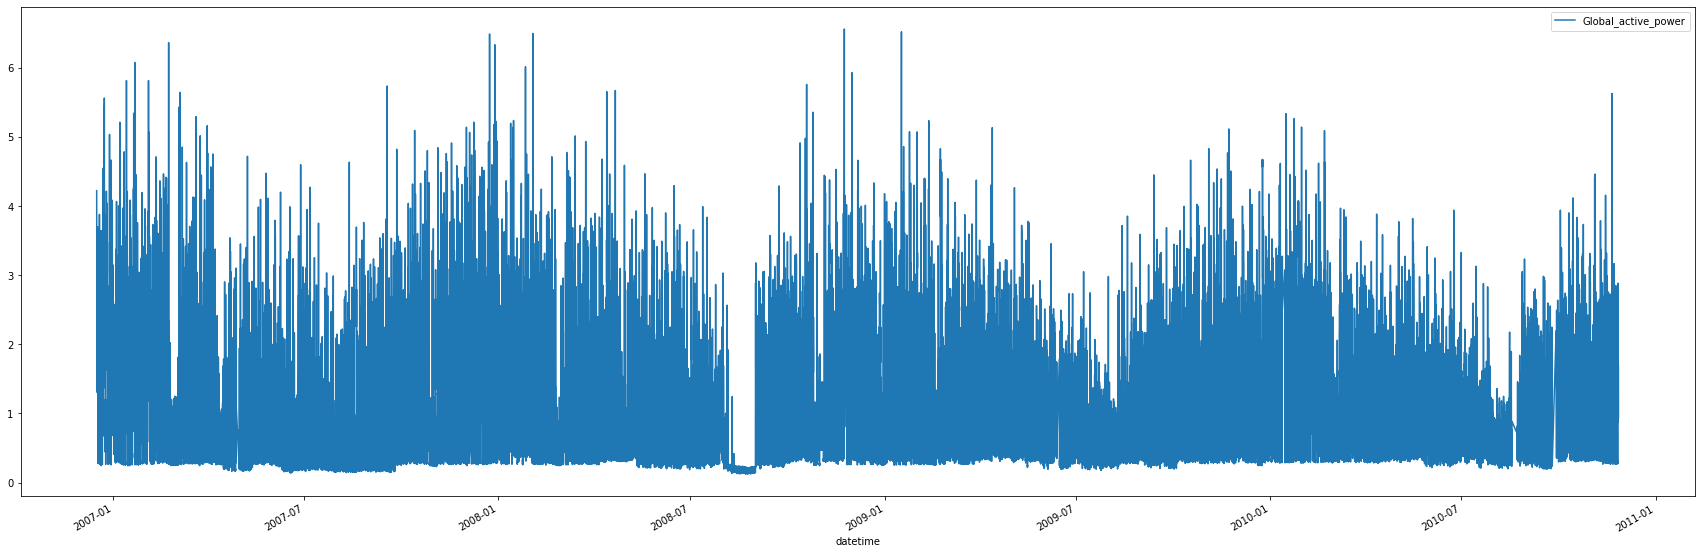

In [ ]:
new_data.plot(figsize=(30,10))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

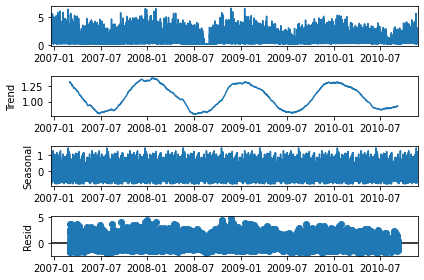

In [ ]:
results = seasonal_decompose(new_data[['Global_active_power']],period=3600)
results.plot();

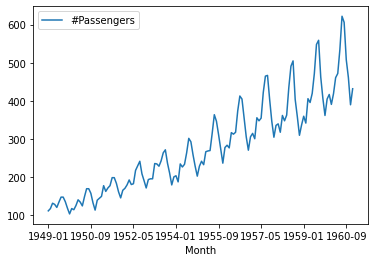

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('AirPassengers.csv', header=0, index_col=0)
series.plot()
pyplot.show()

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = read_csv('AirPassengers.csv', header=0, index_col=0)
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pyplot.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
new_data[['Global_active_power']].head()

,Global_active_power
datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


In [ ]:
date_index=new_data.index.to_series()

## Adding some features... 

In [ ]:
def adding_hour_feature(hour):
    for index in date_index:
        if index-timedelta(hours=hour) in new_data.index:
            new_data.loc[index,f"hour-{hour}"]=new_data.loc[index-timedelta(hours=hour),'Global_active_power']
        else:
            new_data.loc[index,f"hour-{hour}"]=new_data.loc[index-timedelta(hours=hour)+timedelta(days=1),'Global_active_power']
    return new_data

In [ ]:
def adding_day_feature(day)
    for index in date_index:
        if index-timedelta(days=day) in new_data.index:
            if ((index-timedelta(days=day)).weekday() > 4 and index.weekday() <= 4 ) or ((index-timedelta(days=day)).weekday() <= 4 and index.weekday() > 4 ):
                if index-timedelta(weeks=1) in new_data.index:
                    new_data.loc[index,f"day-{day}"]=new_data.loc[index-timedelta(weeks=1),'Global_active_power']
                else:
                    new_data.loc[index,f"day-{day}"]=new_data.loc[index+timedelta(weeks=1),'Global_active_power']
            else:
                new_data.loc[index,f"day-{day}"]=new_data.loc[index-timedelta(days=day),'Global_active_power']
        else:
            new_data.loc[index,f"day-{day}"]=new_data.loc[index-timedelta(days=day)+timedelta(weeks=1),'Global_active_power']
    return new_data

In [ ]:
def adding_week_feature(week):
    for index in date_index:
        if index-timedelta(weeks=week) in new_data.index:
            new_data.loc[index,f"week-{week}"]=new_data.loc[index-timedelta(weeks=week),'Global_active_power']
        else:
            new_data.loc[index,f"week-{week}"]=new_data.loc[index+timedelta(weeks=week),'Global_active_power']
    return new_data

In [ ]:
def adding_TimeDate_feature(data,date_index)
    data['year']=date_index.dt.year
    data['month']=date_index.dt.month_name()
    data['day_of_week']=date_index.dt.day_name()
    data['hour']=date_index.dt.hour
    data['weekend']=date_index.dt.dayofweek>4
    data=data.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
    return data

In [ ]:
def normalizing_data(raw_df,data):
    numerical_cols=['hour-1','hour-2','hour-3','hour-4','hour-5','hour-6','day-1','day-2','day-3','day-4','week-1','week-2','week-3','week-4']
    scaler = MinMaxScaler().fit(raw_df[numerical_cols])
    normlized_data[numerical_cols] = scaler.transform(data[numerical_cols]) 
    return normlized_data

In [ ]:
def encoding_data(raw_df,data):
    categorical_cols=['weekend']
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])
    encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
    encoded_data[encoded_cols] = encoder.transform(data[categorical_cols])
    return encoded_data,encoded_cols


In [ ]:
def split_data(raw_df):
    train_data=raw_df[raw_df.year<2010]
    test_data=raw_df[raw_df.year==2010]
    
    #creating diff columns...and splitting data into.. input and target
    input_cols=['hour-1','hour-2','hour-3','hour-4','hour-5','hour-6','day-1','day-2','day-3','day-4','week-1','week-2','week-3','week-4','weekend']
    target_cols=['Global_active_power']
    
    train_input=train_data[input_cols].copy()
    train_target=train_data[target_cols].copy()
    test_input=test_data[input_cols].copy()
    test_target=test_data[target_cols].copy()
return train_input,train_target,test_input,test_target

In [ ]:
X_train = train_input[numerical_cols+encoded_cols]
X_test = test_input[numerical_cols+encoded_cols]

In [ ]:
model=RandomForestRegressor(random_state=42,
                            n_jobs=-1)
model.fit(X_train, train_target.values.ravel())
model.score(X_train, train_target),model.score(X_test, test_target)

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df

In [ ]:
model=RandomForestRegressor(random_state=42,
                            n_jobs=-1,
                            max_depth=10,
                            max_leaf_nodes=2**10,
                           max_features='log2',
                           min_impurity_decrease=1e-6)
model.fit(X_train, train_target.values.ravel())
model.score(X_train, train_target),model.score(X_test, test_target)

### Adding Some Features... 

In [ ]:
for month,month_df in temp_data.groupby('month'): 
    for week,week_df in month_df.groupby('day_of_week'):
        for hour,hour_df in week_df.groupby('hour'):
            mean=hour_df.Global_active_power.mean()
            std=hour_df.Global_active_power.std()
            for index in hour_df.index:
                temp_data.loc[index,'mean']=mean
                temp_data.loc[index,'std']=std  

# pca

In [ ]:
raw_df.head(10)

xt=raw_df.drop(["weekend","year","day_of_week","month","hour"],axis=1)
xt

In [ ]:
xt.to_csv("mydata.csv")

In [ ]:
pca = PCA(0.95)
data=pca.fit_transform(xt)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
xt_column=[xt.columns]
xt_index=[xt.index.values]
yt=pd.DataFrame(data,index=xt_index)
yt

# printing....

In [ ]:
temp_data=new_data[new_data.year>2006] 

In [ ]:
temp_data.columns

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(30,15))
weekend=temp_data.weekend.astype(float)
ax = sns.boxplot(x=temp_data.hour, y=temp_data.Global_active_power,hue=weekend,data=temp_data)

In [ ]:
plt.figure(figsize=(30,15))
weekday=temp_data.day_of_week
ax = sns.boxplot(x=temp_data.hour, y=temp_data.Global_active_power,hue=weekday,data=temp_data)

In [ ]:
plt.figure(figsize=(25,15))
month_name=temp_data.month
ax = sns.boxplot(x=temp_data.hour, y=temp_data.Global_active_power,hue=month_name,data=temp_data)

In [ ]:
plt.scatter(temp_data.hour,temp_data.Global_active_power)

In [ ]:
plt.scatter(temp_data.weekend,temp_data.Global_active_power)

In [ ]:
plt.scatter(temp_data.month,temp_data.Global_active_power)

In [ ]:
plt.figure(figsize=(30,15))
ax = sns.boxplot(x=temp_data.month, y=temp_data.Global_active_power,data=temp_data)

In [ ]:
plt.scatter(temp_data.day_of_week,temp_data.Global_active_power)

In [ ]:
plt.figure(figsize=(30,15))

ax = sns.boxplot(x=temp_data.day_of_week, y=temp_data.Global_active_power,data=temp_data)

# Grid Search CV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'max_depth': [8,10],
    'min_samples_split': [2,4],
    'n_estimators': [int(x) for x in range(100, 500, 100)]}

In [ ]:
model=RandomForestRegressor()
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)
grid_search.fit(X_train,train_target)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_